ModComp Notebook!

tree.csv
vert_genes.csv

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [8]:
# Step 1: Read the data
vert_genes = pd.read_csv('data/vert_genes.csv')
tree = pd.read_csv('data/tree.csv')

In [9]:
tree_dict = {}
for index, row in tree.iterrows():
    parent = row['Parent']
    child = row['Child']
    age = row['age_ch']
    t = row['t']
    species = row['species']
    if parent not in tree_dict:
        tree_dict[parent] = {'children': [], 'ages': {}, 'species': {}}
    if child not in tree_dict:
        tree_dict[child] = {'children': [], 'ages': {}, 'species': {}}
    tree_dict[parent]['children'].append(child)
    tree_dict[parent]['ages'][child] = age
    tree_dict[parent]['species'][child] = species
    tree_dict[child]['ages'][parent] = age
    tree_dict[child]['species'][parent] = species

In [10]:
tree_dict

{222.0: {'children': [1, 2],
  'ages': {1: 0.0, 2: 0.0, 221.0: 9.00025},
  'species': {1: 'Peromyscus_maniculatus', 2: 'Mus_musculus', 221.0: nan}},
 1: {'children': [],
  'ages': {222.0: 0.0},
  'species': {222.0: 'Peromyscus_maniculatus'}},
 2: {'children': [], 'ages': {222.0: 0.0}, 'species': {222.0: 'Mus_musculus'}},
 221.0: {'children': [3, 222],
  'ages': {3: 0.0, 220.0: 12.17270627787635, 222: 9.00025},
  'species': {3: 'Cricetulus_griseus', 220.0: nan, 222: nan}},
 3: {'children': [],
  'ages': {221.0: 0.0},
  'species': {221.0: 'Cricetulus_griseus'}},
 220.0: {'children': [4, 221],
  'ages': {4: 0.0, 219.0: 14.6842691563933, 221: 12.17270627787635},
  'species': {4: 'Rattus_norvegicus', 219.0: nan, 221: nan}},
 4: {'children': [],
  'ages': {220.0: 0.0},
  'species': {220.0: 'Rattus_norvegicus'}},
 219.0: {'children': [5, 220],
  'ages': {5: 0.0, 218.0: 17.062881393960126, 220: 14.6842691563933},
  'species': {5: 'Mesocricetus_auratus', 218.0: nan, 220: nan}},
 5: {'children':

In [11]:
# Step 3: Define the parameters for the Bayesian network
alpha_0 = 50000
sigma_0_sq = 5000
alpha = 0
beta = 1
sigma_sq = 2500

In [12]:
# Step 4: Implement a function to simulate the data for each node in the tree
def simulate_data(node, parent_data=None):
    if node.startswith('X'):
        species = tree_dict[node]['species'][parent_node]
        gene_length = vert_genes.loc[vert_genes['species'] == species]['glength'].values[0]
        t = tree_dict[parent_node]['ages'][node]
        mean = alpha*t + beta*parent_data + gene_length
        var = sigma_sq*t
        data = np.random.normal(mean, np.sqrt(var))
        return data
    elif node == 'Z0':
        mean = alpha_0
        var = sigma_0_sq
        data = np.random.normal(mean, np.sqrt(var))
        return data
    else:
        parent_node = tree_dict[node]['ages'].keys()[0]
        t = tree_dict[parent_node]['ages'][node]
        mean = alpha*t + beta*parent_data
        var = sigma_sq*t
        data = np.random.normal(mean, np.sqrt(var))
        return data

In [17]:
# Step 5: Simulate the data for the entire tree
data_dict = {}
for node in tree_dict:
    parent_node = list(tree_dict[node]['ages'].keys())[0] if node != 'Z0' else None
    parent_data = data_dict[parent_node] if node != 'Z0' and parent_node in data_dict else None
    data_dict[node] = simulate_data(node, parent_data)


# Step 6: Visualize the simulated data for one example species

In [23]:
#sanity check
print(vert_genes.loc[vert_genes['species'] == example_species])

        ensembl_id orthId  glength       species
130      NP_001745  1CPN2   256765  Homo_sapiens
334      NP_075045  1CQBX    40682  Homo_sapiens
537   XP_016874467  1CQJ6    37952  Homo_sapiens
740      NP_002599  1CR8Z    18241  Homo_sapiens
942      NP_001143  1CTEU     2543  Homo_sapiens
1146  XP_016884480  1CTI9    43475  Homo_sapiens
1350  XP_005253073  1CYBB   134950  Homo_sapiens
1541     NP_061138  1D0EM    23275  Homo_sapiens
1738     NP_002209  1D1CF    17222  Homo_sapiens
1936     NP_000919  1D3F1     5561  Homo_sapiens


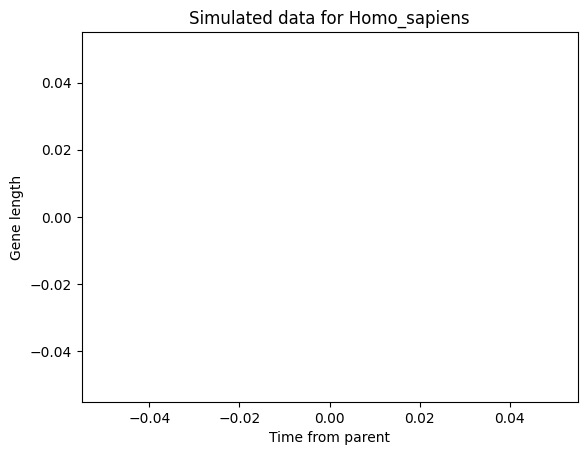

In [24]:
# Step 6: Visualize the simulated data for one example species
example_species = 'Homo_sapiens'
x_data = []
y_data = []
for node in tree_dict:
    if node.startswith('X') and tree_dict[node]['species'][tree_dict[node]['ages'].keys()[0]] == example_species:
        parent_node = tree_dict[node]['ages'].keys()[0]
        x_data.append(tree_dict[parent_node]['ages'][node])
        y_data.append(data_dict[node])
plt.scatter(x_data, y_data)
plt.xlabel('Time from parent')
plt.ylabel('Gene length')
plt.title('Simulated data for ' + example_species)
plt.show()


# Step 7: Fit a linear regression model of Z0 given X1, ..., Xn

In [25]:
# Step 7: Fit a linear regression model of Z0 given X1, ..., Xn
X = []
y = []
for node in tree_dict:
    if node.startswith('X'):
        X.append(data_dict[node])
    elif node == 'Z0':
        y.append(data_dict[node])
X = np.array(X).reshape(-1, 1)
y = np.array(y)
model = LinearRegression()
model.fit(X, y)
print('The estimated coefficient beta is:', model.coef_[0])
print('The estimated intercept alpha_0 is:', model.intercept_)


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.


Note that in Step 6, we only visualize the simulated data for one example species (`Homo_sapiens`). To visualize the data for all species, we can loop over all the species in `vert_genes.csv` and plot the data separately for each species.

In Step 7, we fit a linear regression model of $Z_0$ given $X_1, \ldots, X_n$ using the simulated data. We print the estimated coefficient `beta` and intercept `alpha_0`. We can compare these estimates with the true values of `beta=1` and `alpha_0=50000` to see how well the model fits the data. We can also compute the mean squared error (MSE) between the true and estimated values to quantify the accuracy of the model.
